# Predictions 
## Niccolò Simonato 
## Data & Web Mining, Academic Year 2021-2022

## Importing the dependencies and the cleaned dataset

The cleaned dataset is now imported.

The first snipped is intended to be used in the Google Drive environment, just set the path variable as needed.

The second one is intended to be used in the Jupyter Notebook environment.

In [1]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import floor, log10
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# path = '/gdrive/MyDrive/Progetto DWM/Data/*.csv'
# %cd /gdrive

In [3]:
path = 'Data/'

# cleaned_df = pd.read_csv(path, low_memory = False)
train_datasets = []
test_datasets = []

for i in range(4):
    train_datasets.append(pd.read_csv(f"{path}train_dataset_2016_{i + 1}.csv", low_memory = True))
    test_datasets.append(pd.read_csv(f"{path}test_dataset_2016_{i + 1}.csv", low_memory = True))

## Data Validation
In order to prevent any exception to be raised, we will check the state of each dataset and will ensure that the data can be used.

In [4]:
train_datasets[1].describe(include='all')

,Unnamed: 0,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,latitude,longitude,lotsizesquarefeet,...,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,N-LivingAreaError,N-LivingAreaProp,N-ValueRatio,N-LogTaxScore,DD,N-DaysInCurrentYear
count,63945.000000,6.394500e+04,63945.000000,63945.000000,63945.000000,63945.000000,63945.000000,63945.000000,63945.000000,63945.000000,...,63945.0,63945.000000,63945.000000,63945.000000,63945.0,63945.000000,63945.000000,63945.000000,63945.000000,63945.000000
mean,48882.100227,1.300342e+07,2.272383,3.005145,5.520320,1744.500774,1744.500774,45.123354,66.106881,3.976152,...,2015.0,5.208905,5961.794141,0.012324,1.0,0.251780,76.103164,9.148952,16.356807,164.286027
std,28905.336939,2.423721e+06,0.941331,1.010511,1.531799,904.481611,904.481611,18.146744,19.240454,0.471434,...,0.0,0.478561,6908.052778,0.155913,0.0,0.208977,32.475617,0.682353,9.002009,85.762695
min,0.000000,1.071174e+07,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,2.222716,...,2015.0,2.973128,64.000000,-3.194000,1.0,0.000179,2.548288,4.824880,1.000000,1.000000
25%,16874.000000,1.154290e+07,2.000000,2.000000,4.000000,1172.000000,1172.000000,31.704379,54.464561,3.740521,...,2015.0,4.912222,2868.820000,-0.024300,1.0,0.142578,70.579142,8.756067,8.000000,97.000000
50%,56386.000000,1.258800e+07,2.000000,3.000000,5.565407,1516.000000,1516.000000,46.238134,67.877974,3.850340,...,2015.0,5.285692,4534.620000,0.006000,1.0,0.214267,79.546204,9.182151,16.000000,167.000000
75%,73348.000000,1.425320e+07,3.000000,4.000000,7.000000,2059.000000,2059.000000,56.600059,80.998193,4.056600,...,2015.0,5.538953,6865.160000,0.038300,1.0,0.311500,84.462565,9.560981,24.000000,232.000000
max,90272.000000,1.629608e+08,20.000000,10.000000,12.000000,20013.000000,20013.000000,100.000000,100.000000,6.843296,...,2015.0,7.389166,321936.090000,4.737000,1.0,11.497006,4997.622067,12.951033,31.000000,365.000000


Since we don't have any real use for it, we can drop the `parcelid` feature.

In [5]:
for i in train_datasets:
    i.drop(['parcelid'], axis=1, inplace=True)

for i in test_datasets:
    i.drop(['parcelid'], axis=1, inplace=True)

## Predictions - Attempt 1 - k-NN algorithm

### Why k-NN? - Introduction 
I chose the k-NN algorithm because, usually, the house construction doesn't happen randomly. It's really unusual that a private party builds his own house, with his own money, and wherever he likes: it's more likely that the municipality's dedicated office decides where and how the houses of a given zone are going to be buildt. 

Therefore, i think is safe to assume that houses of a given zone will have similar prices. The k-NN hopefully will help achiving this target. 

This attempt will use the [ScikitLearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) of the k-NN algorithm for prediction.

The first attempt will be conducted with the parameter `weights` set as "uniform", the second one will use the value "distance".

The model will be tested with a number of neighbors beetween 6 and 8, because usually these are the value that yield the best results.

The following snippet contains the functions that wraps the described procedure.

In [6]:
n_neighbors = [3,4,5,6,7,8]
    
def train_test_kNN(x_train, y_train, x_test, y_test, n_neighbors, w='distance'):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=w)
    model = knn.fit(x_train, y_train)
    prediction = model.predict(x_test)
    scores = model.score(x_test, y_test)
    data = {'n_neighbors': n_neighbors, 
            'weights': w,
            'prediction': prediction,
            'score' : scores,
            'MSE': mean_squared_error(y_test,prediction)
           }
    return data

In [ ]:
%%time
results = []
types = ['distance', 'uniform']
to_Y = ['logerror']
to_X = list(set(train.columns) - set('logerror'))
train, test = None, None
for i in range(len(train_datasets)):
    train = train_datasets[i]
    test  = test_datasets[i]
    for n in n_neighbors:
        for w in types:
            print(f"Using dataset {i + 1} at {datetime.now()}: n_neighbor = {n}, weight = {w}")
            results.append(train_test_kNN(train[to_X], train[to_Y], test[to_X], test[to_Y], n, w))      
            print(f"Experiment ended succesfully at {datetime.now()}. " + 
                  f"ETA: {(len(train_datasets) - i)*(len(n_neighbors) - (n - 2))} minutes")

Using dataset 0 at 2022-06-10 17:43:09.199022: n_neighbor = 3, weight = distance
Experiment number 0 ended succesfully at 2022-06-10 17:43:37.014510. ETA: 72 minutes
Using dataset 0 at 2022-06-10 17:43:37.014510: n_neighbor = 3, weight = uniform
Experiment number 0 ended succesfully at 2022-06-10 17:44:08.533146. ETA: 72 minutes
Using dataset 0 at 2022-06-10 17:44:08.533146: n_neighbor = 4, weight = distance
Experiment number 0 ended succesfully at 2022-06-10 17:44:45.115288. ETA: 72 minutes
Using dataset 0 at 2022-06-10 17:44:45.116009: n_neighbor = 4, weight = uniform
Experiment number 0 ended succesfully at 2022-06-10 17:45:21.444762. ETA: 72 minutes
Using dataset 0 at 2022-06-10 17:45:21.444762: n_neighbor = 5, weight = distance
Experiment number 0 ended succesfully at 2022-06-10 17:45:59.426635. ETA: 72 minutes
Using dataset 0 at 2022-06-10 17:45:59.426635: n_neighbor = 5, weight = uniform
Experiment number 0 ended succesfully at 2022-06-10 17:46:34.589134. ETA: 72 minutes
Using d

### How did it go? - Evaluation
After obtaining the results, we can proceed with the evaluation of the results.

In order to keep this notebook as clean as possible, the evaluation will be done with the built-in evaluator of the KNeighborsRegressor object. The built-in functions uses the $R^2$ index, the coefficient of determination that is $1 - \frac{u}{v}$, where $u$ is the residual sum of squares and $v$ is the total sum of squares.

In [8]:
def show_results_kNN(data):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for parameters in data:
        if parameters['weights'] == "uniform":
            ax1.scatter(parameters['n_neighbors'], parameters['score'], color='darkorange', label='data')
            ax1.get_yaxis().get_major_formatter().set_useOffset(False)
        else:
            ax2.scatter(parameters['n_neighbors'], parameters['score'], color='blue', label='data')
            ax2.get_yaxis().get_major_formatter().set_useOffset(False)
    plt.xticks(ticks=n_neighbors)
    plt.xlabel("Number of neighbors")
    plt.title(f"KNeighborsRegressor")   
    plt.show()

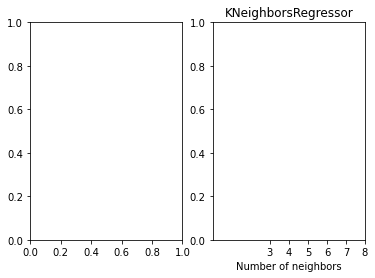

In [9]:
show_results_kNN(results)

Basing on these results, it seems like the best results are yielded by using the weights parameter set as ‘distance’ (it weights points by the inverse of their distance, so closer neighbors of a query point will have a greater influence).

It is necessary to remind that by default the "distance" used in those cases is the Minkowski distance. With other parameters, it may have yielded other results, but for the purpose of this project it is a reasonable choice.

These results yielded a comparable score, but it still looks like they get better as the number of neighbors considered increases.

Let's retry the experiments with higher numbers of `n_neighbors`. This time, we will use the 'distance' value for the `weights` parameter, since it's clear that there are no significant differences between the different test.

In [10]:
%%time
n_neighbors += [9,10,11]
for i in range(len(train_datasets)):
    train = train_datasets[i]
    test  = test_datasets[i]
    for n in [9,10,11]:
        print(f"Using dataset {i} at {datetime.now()}: n_neighbor = {n}, weight = {w}")
        results.append(train_test_kNN(train[to_X], train[to_Y], test[to_X], test[to_Y], n))      
        print(f"Experiment number {i} ended succesfully at {datetime.now()}. " + 
              f"ETA: {(len(train_datasets) - i)*(len(n_neighbors) - (n - 8))} minutes")

NameError: name 'w' is not defined

Let's plot the results

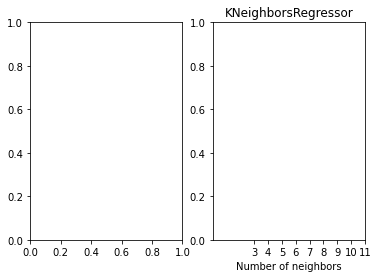

In [11]:
show_results_kNN(results)

Even though it looks like it slowly gets better as $k$ increases, the results still are very low.

## Predictions - Attempt 2 - Linear Regression

### Why Linear Regression? - Introduction
The idea behind the adoption of the LinReg model is correlated to the low integrity of the inititial dataset. 

In contrast with the previously analyzed model, this is an attempt to see what would happen with an "assumption-free" model. It is expected that this type of analysis will underline some unseen correlations, and also will produce some interesting predictions.

This test will be conducted with the [ScikitLearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) of the LinearRegression.

In [12]:
def train_test_LinReg(x_train, y_train, x_test, y_test):
    model = LinearRegression().fit(x_train, y_train)
    predictions = model.predict(x_test)
    data = {
        'predictions': predictions,
        'R_sq': model.score(x_test, predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'Adj_R_sq': 1 - (1-model.score(x_test, predictions))*(len(predictions)-1)/(len(predictions)-x_test.shape[1]-1)
    }
    return data

In [13]:
%%time
res = []
to_Y = ['logerror']
to_X = list(set(train.columns) - set('logerror'))
for i in range(len(train_datasets)):
    train = train_datasets[i]
    test  = test_datasets[i]
    for n in n_neighbors:
        for w in types:
            res.append(train_test_LinReg(train[to_X], train[to_Y], test[to_X], test[to_Y]))

CPU times: total: 13.9 s
Wall time: 3.63 s


### How did it go? - Evaluation
We can now proceed with the evaluation of the results.

The following tests will be used:


*  Mean Squared Error
*  R-squared index
*  Adjusted R-squared index


The evaluations will be done by using the [ScikitLearn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module.

In [14]:
def show_results_LinReg(results):
    for i in range(len(results)):
        parameters = results[i]
        print(f"Experiment number {i}: {' ' * (4 - floor(log10(i + 1)))} R_sq index = {parameters['R_sq']}, " + 
              f"MSE = {parameters['MSE']}, Adj_R_sq index = {parameters['Adj_R_sq']}")

In [15]:
show_results_LinReg(res)

Experiment number 0:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 1:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 2:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 3:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 4:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 5:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 6:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 7:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 8:      R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 9:     R_sq index = 1.0, MSE = 8.56091832944962e-32, Adj_R_sq index = 1.0
Experiment number 10:     R_sq index = 1.0, MSE = 8.56091832944962e-32,

By looking at the results it is clear that the results are too good to be true. It is clear that this is a case of overfitting. [This article](https://statisticsbyjim.com/regression/r-squared-too-high/) explains the other possible reasons of these results.

There are two main reasons for this kind of result:

- `Wrong algorithm/approach`: the first and most probable cause, is the inner workings of the Linear Regression: it may just be the wrong model to obtain any useful information from.

- `Biased evaluation indexes`: the second possibile cause is a bias contained in the testing measures. The analysis of other indexes may yield some more interesting results, but for now is impossible to declare the precise reason for the over-fitting to happen.

### Conclusions

It is clear that the first regression algorithm is a more reasonable choice to do then the second one. 

The latter suffers from a clear case of over-fitting, so the results are totally biased.

The k-NN algorithm didn't get the expected results, all the evaluation measures turned out to be very low.
The causes may be found in the inadequacy of this algorithm to the context. It is advisable to use different algorithms and a more complete dataset to retrieve better results.